In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import Dataset

import os
from glob import glob
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seed = 1

lr = 0.001
momentum = 0.5

batch_size = 64
test_batch_size = 64

epochs = 5

no_cuda = False
log_interval = 100

In [3]:
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

## Model

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # feature extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)        
        #print(x.shape)
        
        # fully-connected
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Preprocess

In [7]:
import os

In [11]:
os.listdir('dataset/mnist_png/')

['training', 'testing']

In [12]:
train_dir = 'dataset/mnist_png/training'
test_dir = 'dataset/mnist_png/testing'

In [13]:
torch.manual_seed(seed)

In [14]:
train_dataset = datasets.ImageFolder(root=train_dir, 
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.5,), std=(0.5,))
                                    ]))

test_dataset = datasets.ImageFolder(root=test_dir, 
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.5,), std=(0.5,))
                                    ]))

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size)

## Train

In [17]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs+1):
    # Train mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} {}/{} ({:.0f}%)\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), 
                loss.item()))
            
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()    
            pred = output.argmax(dim=1, keepdim=True)    
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {} / {} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), 100 * correct / len(test_loader.dataset)))

## cifar

In [5]:
from glob import glob
train_paths = glob('dataset/cifar/train/*.png')
test_paths = glob('dataset/cifar/test/*.png')                   

In [6]:
path = train_paths[0]
path

'dataset/cifar/train/39769_automobile.png'

In [7]:
os.path.basename(path).split('_')[-1].replace('.png', '')

'automobile'

In [8]:
def get_label(path):
    return os.path.basename(path).split('_')[-1].replace('.png', '')

In [9]:
label_names = [get_label(path) for path in train_paths]
classes = np.unique(label_names)

In [10]:
classes

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [12]:
label = np.argmax(np.array(classes == get_label(path), dtype=np.uint8))
label

1

In [13]:
img_pil = Image.open(path)
image = np.array(img_pil)

In [14]:
image.shape

(32, 32, 3)

In [15]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class CustomImageDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        path = self.data_paths[idx]
        # image
        image = np.array(Image.open(path))
        
        # label
        label = np.argmax(classes == get_label(path))
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [16]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [17]:
train_loader = torch.utils.data.DataLoader(CustomImageDataset(train_paths, transforms.Compose([
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=(0.5,), std=(0.5,))
                                            ])),
                                           batch_size=batch_size,
                                           shuffle=True,
                                          **kwargs)

test_loader = torch.utils.data.DataLoader(CustomImageDataset(test_paths, transforms.Compose([
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=(0.5,), std=(0.5,))
                                            ])),
                                           batch_size=batch_size,
                                          **kwargs)

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(5*5*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # feature extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)        
        #print(x.shape)
        
        # fully-connected
        x = x.view(-1, 5*5*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [27]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs+1):
    # Train mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} {}/{} ({:.0f}%)\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), 
                loss.item()))
            
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()    
            pred = output.argmax(dim=1, keepdim=True)    
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {} / {} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), 100 * correct / len(test_loader.dataset)))

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Train Epoch: 1 0/50000 (0%)	Loss: 2.302484
Train Epoch: 1 6400/50000 (13%)	Loss: 2.301962
Train Epoch: 1 12800/50000 (26%)	Loss: 2.297244
Train Epoch: 1 19200/50000 (38%)	Loss: 2.291163
Train Epoch: 1 25600/50000 (51%)	Loss: 2.292508
Train Epoch: 1 32000/50000 (64%)	Loss: 2.288110
Train Epoch: 1 38400/50000 (77%)	Loss: 2.282538
Train Epoch: 1 44800/50000 (90%)	Loss: 2.274831


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Test set: Average loss: 2.2732, Accuracy: 2312 / 10000 (23%)
Train Epoch: 2 0/50000 (0%)	Loss: 2.270543


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Train Epoch: 2 6400/50000 (13%)	Loss: 2.275399
Train Epoch: 2 12800/50000 (26%)	Loss: 2.242211
Train Epoch: 2 19200/50000 (38%)	Loss: 2.228469
Train Epoch: 2 25600/50000 (51%)	Loss: 2.194077
Train Epoch: 2 32000/50000 (64%)	Loss: 2.216904
Train Epoch: 2 38400/50000 (77%)	Loss: 2.239618
Train Epoch: 2 44800/50000 (90%)	Loss: 2.186610


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Test set: Average loss: 2.1238, Accuracy: 2445 / 10000 (24%)
Train Epoch: 3 0/50000 (0%)	Loss: 2.137303


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Train Epoch: 3 6400/50000 (13%)	Loss: 2.218004
Train Epoch: 3 12800/50000 (26%)	Loss: 2.108078
Train Epoch: 3 19200/50000 (38%)	Loss: 1.952466
Train Epoch: 3 25600/50000 (51%)	Loss: 2.064689
Train Epoch: 3 32000/50000 (64%)	Loss: 2.051429
Train Epoch: 3 38400/50000 (77%)	Loss: 2.150273
Train Epoch: 3 44800/50000 (90%)	Loss: 2.115367


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Test set: Average loss: 1.9829, Accuracy: 2989 / 10000 (30%)
Train Epoch: 4 0/50000 (0%)	Loss: 2.117625


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Train Epoch: 4 6400/50000 (13%)	Loss: 2.040134
Train Epoch: 4 12800/50000 (26%)	Loss: 1.867560
Train Epoch: 4 19200/50000 (38%)	Loss: 2.009491
Train Epoch: 4 25600/50000 (51%)	Loss: 1.977992
Train Epoch: 4 32000/50000 (64%)	Loss: 2.103826
Train Epoch: 4 38400/50000 (77%)	Loss: 1.949861
Train Epoch: 4 44800/50000 (90%)	Loss: 1.838862


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Test set: Average loss: 1.8957, Accuracy: 3190 / 10000 (32%)
Train Epoch: 5 0/50000 (0%)	Loss: 1.731708


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Train Epoch: 5 6400/50000 (13%)	Loss: 1.949561
Train Epoch: 5 12800/50000 (26%)	Loss: 1.837651
Train Epoch: 5 19200/50000 (38%)	Loss: 1.756591
Train Epoch: 5 25600/50000 (51%)	Loss: 1.825047
Train Epoch: 5 32000/50000 (64%)	Loss: 1.790609
Train Epoch: 5 38400/50000 (77%)	Loss: 1.905484
Train Epoch: 5 44800/50000 (90%)	Loss: 1.796577


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)



Test set: Average loss: 1.8418, Accuracy: 3397 / 10000 (34%)


## Understand Better

In [7]:
path = 'puppy.jpeg'

In [8]:
image = Image.open(path)

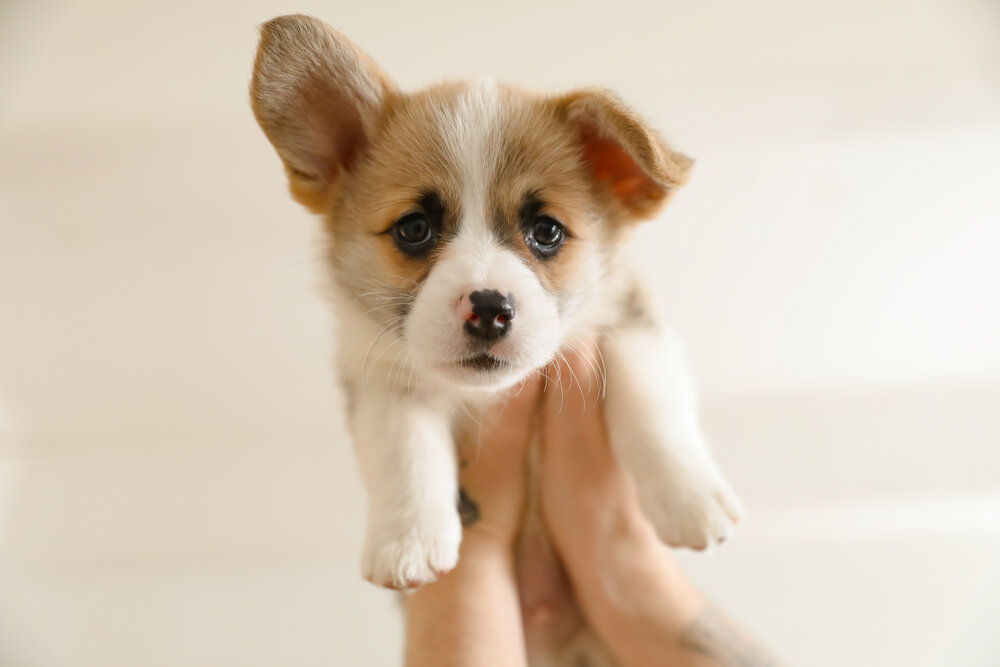

In [9]:
image

In [10]:
np.array(image).shape

(667, 1000, 3)

## center crop

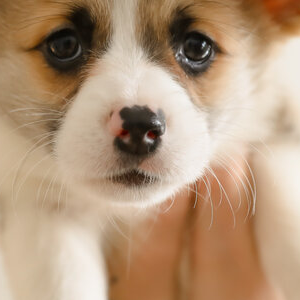

In [12]:
import torchvision
torchvision.transforms.CenterCrop(size=(300,300))(image)

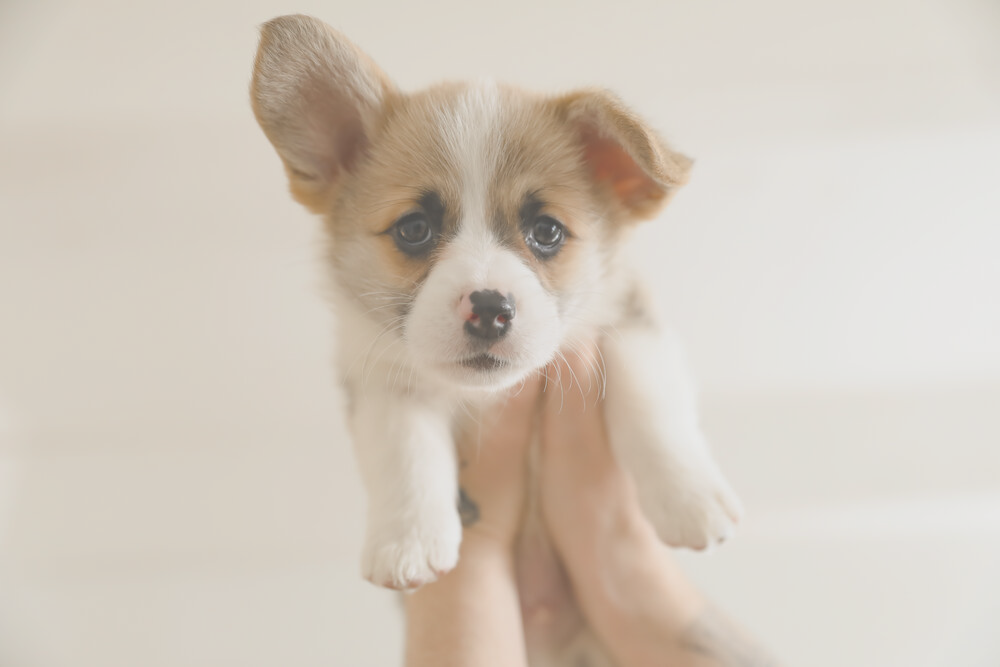

In [13]:
torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0)(image)

In [15]:
crop_images = torchvision.transforms.FiveCrop(size=(300,300))(image)

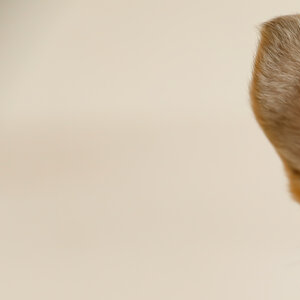

In [17]:
crop_images[0]

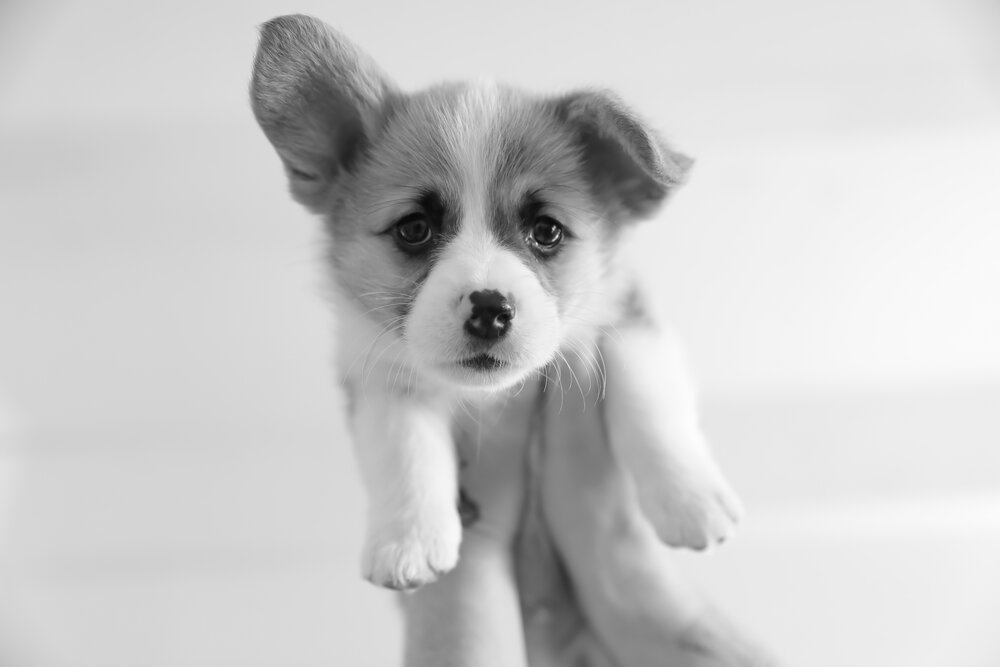

In [20]:
torchvision.transforms.Grayscale(num_output_channels=1)(image)

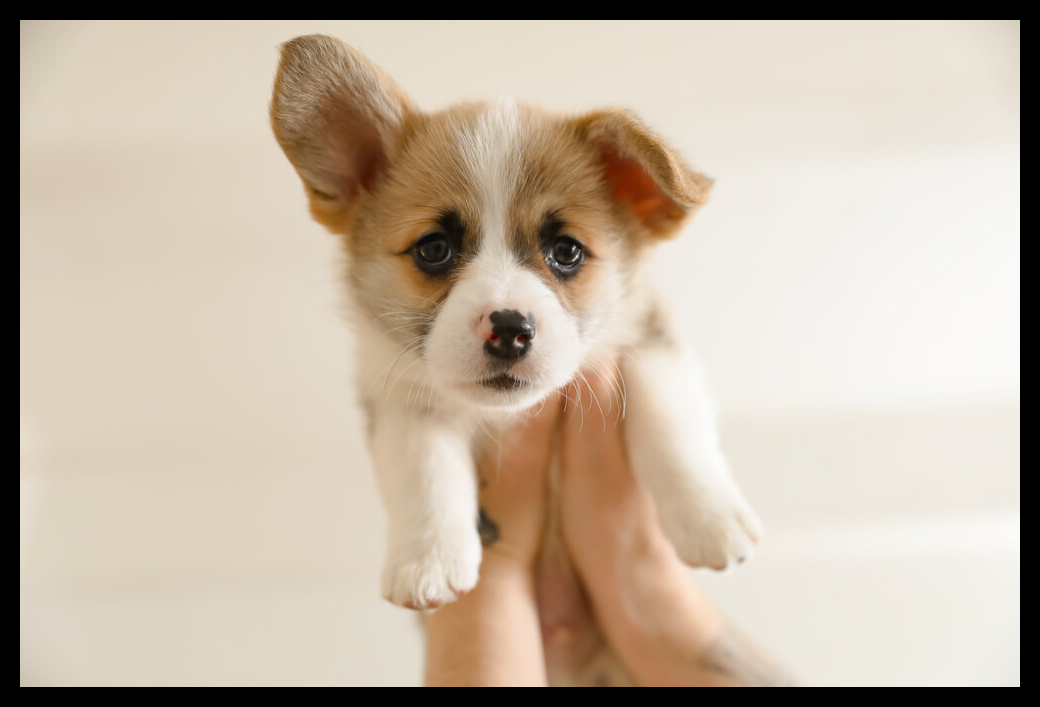

In [21]:
torchvision.transforms.Pad(padding=(20,20), fill=0, padding_mode='constant')(image)

/home/ziippy/venv_tf2/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1357: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


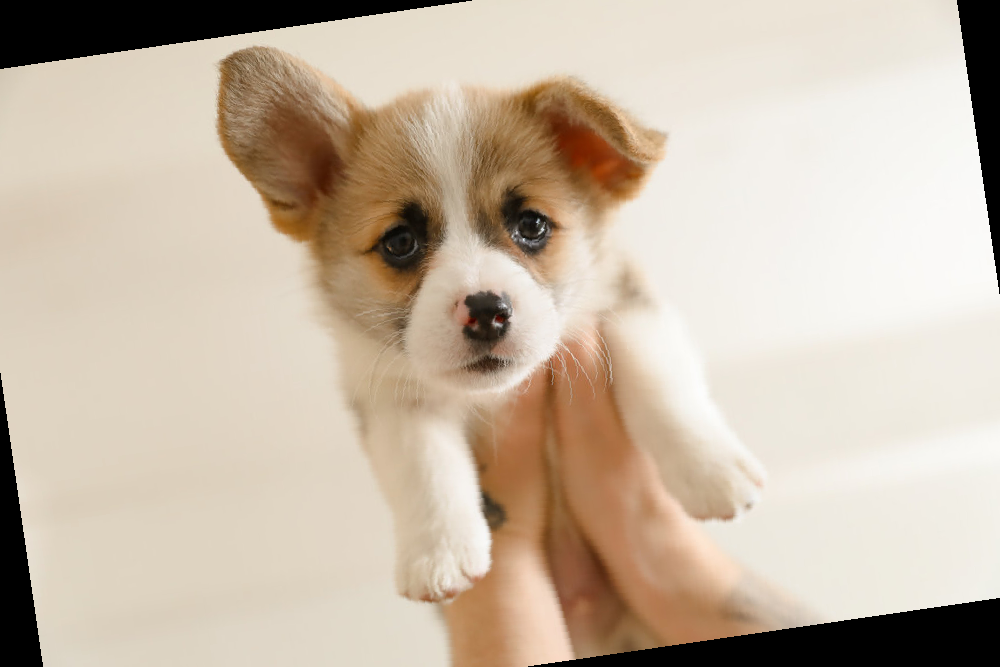

In [23]:
torchvision.transforms.RandomAffine(degrees=90, fillcolor=0)(image)

In [27]:
transforms = [torchvision.transforms.Grayscale(num_output_channels=1),
             torchvision.transforms.CenterCrop(size=(500,500)),
             torchvision.transforms.RandomAffine(degrees=90, fill=0)]

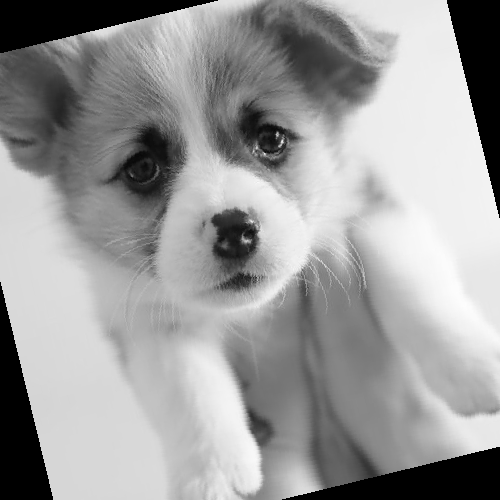

In [28]:
torchvision.transforms.RandomApply(transforms, p=0.5)(image)

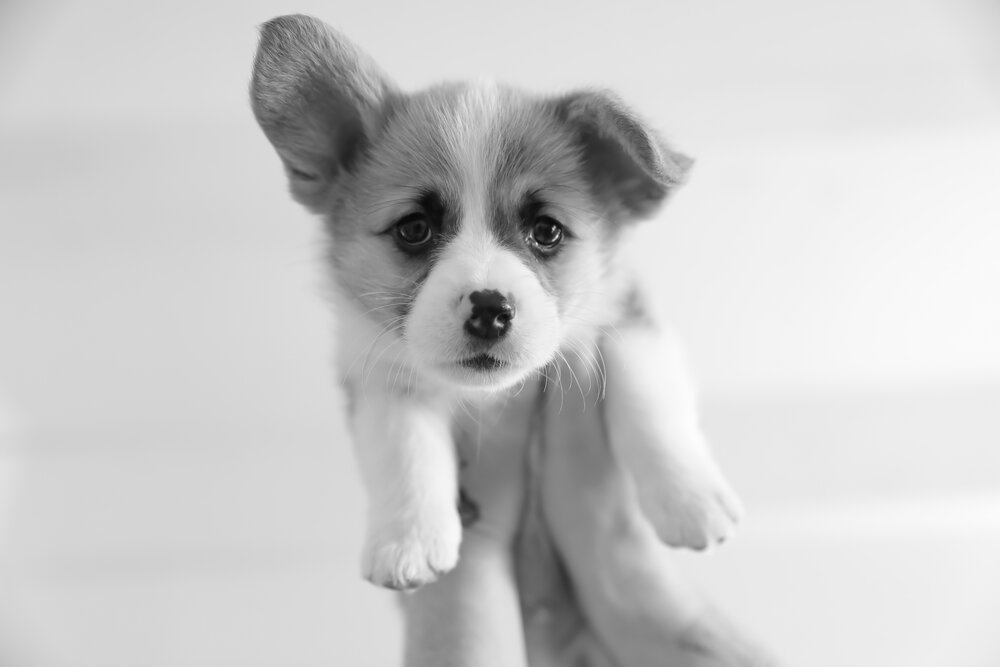

In [29]:
torchvision.transforms.RandomChoice(transforms)(image)

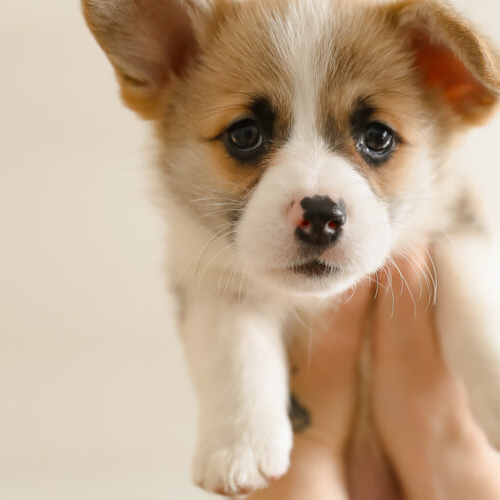

In [32]:
torchvision.transforms.RandomCrop(size=(500, 500))(image)

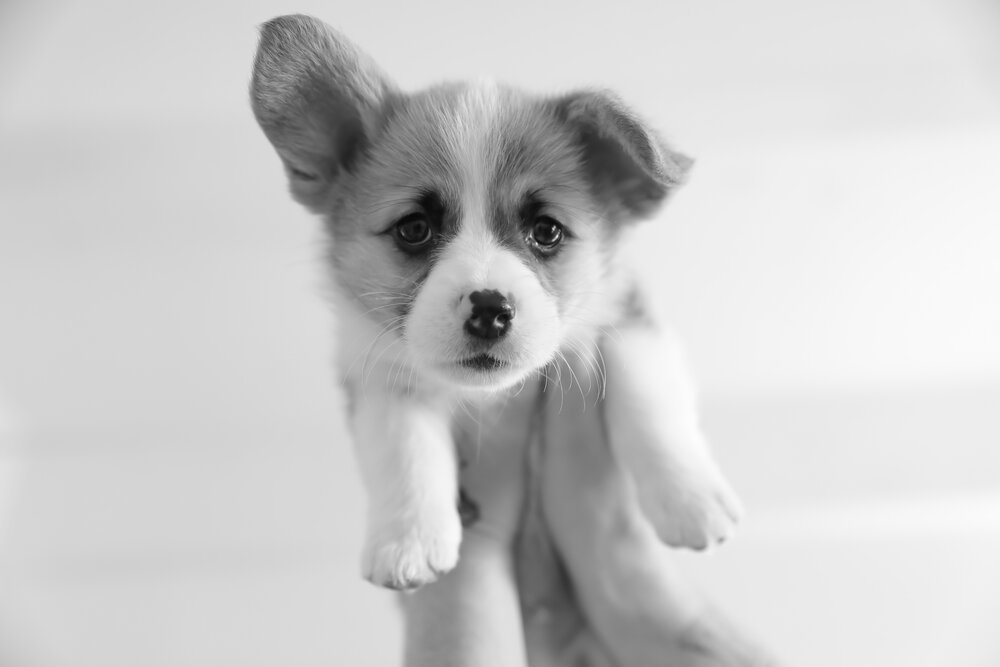

In [33]:
torchvision.transforms.RandomGrayscale(p=0.5)(image)

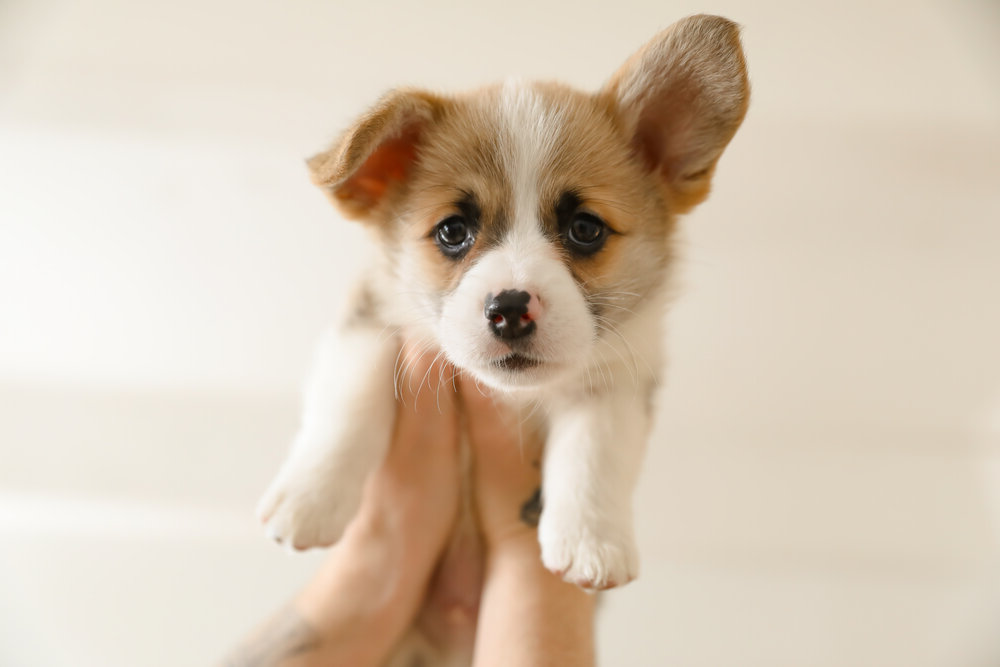

In [36]:
torchvision.transforms.RandomHorizontalFlip(p=0.5)(image)

/home/ziippy/venv_tf2/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


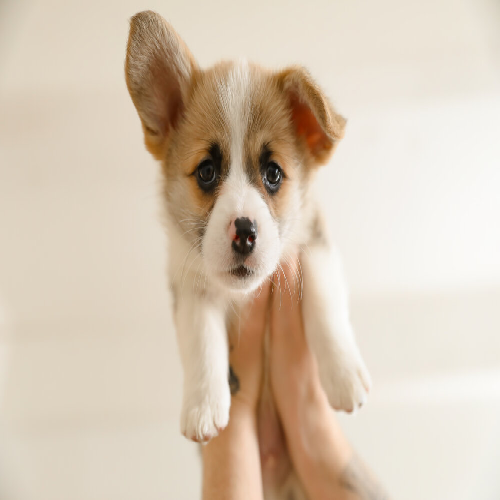

In [39]:
torchvision.transforms.Resize(size=(500, 500), interpolation=Image.NEAREST)(image)

## Transform on Tensor

In [40]:
tensor = torchvision.transforms.ToTensor()(image)

In [41]:
trans = torchvision.transforms.Normalize(mean=(0,0,0), std=(1,1,1))(tensor)

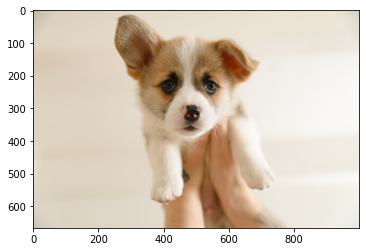

In [43]:
plt.imshow(trans.numpy().transpose(1, 2, 0))

In [44]:
np.min(trans.numpy()), np.max(trans.numpy())

(0.0, 0.99607843)

In [56]:
trans_numpy = trans.numpy()
trans_numpy.shape

(3, 667, 1000)

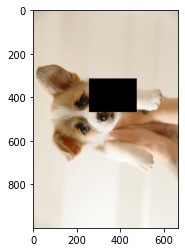

In [57]:
plt.imshow(trans_numpy.transpose(2, 1, 0))

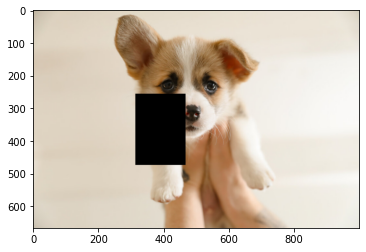

In [55]:
trans = torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)(tensor)
plt.imshow(trans.numpy().transpose(1, 2, 0))